In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import spearmanr
from scipy.stats import pearsonr
import statistics

from sklearn.feature_selection import VarianceThreshold
# for data imbalance, SMOTE
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
#from sklearn.utils import class_weight

# to calculate the performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [297]:
def pearson_COR(spec1,spec2):
    pcorr, _ = pearsonr(spec1,spec2)
    return pcorr

def spearman_COR(spec1,spec2):
    scorr, _ = spearmanr(spec1,spec2)
    return scorr

def pairwise_COR(df):
    pearsonCOR=[]
    spearmanCOR =[]
    for i in range(df.shape[0]):
        for j in range(i+1,df.shape[0]):
            result = spec_COR(df.iloc[i,0:],df.iloc[j,0:])
            pearsonCOR.append(result[0])
            spearmanCOR.append(result[1])
    return pearsonCOR, spearmanCOR

def Pearson_matrix(df,i0):
    COR_pearson = pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR_pearson.loc[i,j] =pearson_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR_pearson

def Spearman_matrix(df,i0):
    COR__spearman= pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR__spearman.loc[i,j] =spearman_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR__spearman

def min_max_scaler(x):
    norm_x = (x-min(x))/(max(x)-min(x))
    return norm_x

Feature dimension of the DFT IR dataset

In [5]:
count = 400
full_feature = []
for i in range(1801):
    #print(count)
    full_feature.append(int(count))
    count += int(2)
print("Number of features:",len(full_feature))
print("First feature:",full_feature[0])
print("Last feature:",full_feature[-1])
col_index = np.arange(1,1802)
print(len(col_index))

Number of features: 1801
First feature: 400
Last feature: 4000
1801


In [6]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"
df = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset.csv")
df_unique = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset - Unique compounds.csv")
df_total_IR_unique = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) conformer weighted total IR - Unique compounds.csv")
print("Number of samples:",df.shape[0],"Number of features:",df.shape[1]-2)
print("Number of unique drug compounds:", df_unique.shape[0])
print(df_total_IR_unique.shape[0])
df.head(2)

Number of samples: 930 Number of features: 1801
Number of unique drug compounds: 127
127


,Drug,Class,400,402,404,406,408,410,412,414,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Heroin_0,1.0,0.008913,0.008557,0.008188,0.007875,0.007665,0.007587,0.007654,0.007875,...,0.000005,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,1.023970e-06,5.107461e-07,0.0
1,Heroin_1,1.0,0.008733,0.008339,0.007896,0.007482,0.007154,0.006941,0.006856,0.006906,...,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,0.000001,9.826807e-07,4.901463e-07,0.0


#### Split original data as 90% training and 10% test

In [7]:
X = df.drop(['Drug','Class'],axis=1)
Y = df['Class'].astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
print('Size of training set',Y_train.shape[0])
print('Size of test set',Y_test.shape[0])

Size of training set 837
Size of test set 93


## I. Prepare datasets

### 0. Remove Low Variance (Quasi constant) Features
Constant features are those that show the same value, just one value, for all the rows of the dataset. 
These features provide no information that allows a machine learning model to discriminate or predict a target.

The Sklearn VarianceThreshold removes all features which variance doesn't meet a certain threshold. 
By default, it removes all zero-variance features.

#### Select the features by examining only the training set to avoid overfit

#### Output: df_variance

In [8]:
def check_low_variance(X_Train):
    # Calculate feature variance
    i = 0
    variance = []
    for column in X_Train:
        i = 1+1
        #print(statistics.variance(df[column]))
        variance.append(statistics.variance(X_Train[column]))
    # Sort in ascending order
    variance.sort()
    plt.hist(variance, bins=100)
    plt.title('Variance distribution')
    plt.show()
    
    #Check number of features to remove for each variance threshold
    features_to_remove = []
    for thres in variance[0:1800]:
        sel = VarianceThreshold(threshold=thres)
        sel.fit_transform(X_Train)
        false_count = (~sel.get_support()).sum()
        features_to_remove.append(false_count)
        print("Variance threshold=",thres, "Number of Features to remove:", false_count)
        true_count = sel.get_support().sum()
        print("Number of Features to retain:", true_count)
        
    fig = plt.figure(figsize=(6,3), dpi=300)
    plt.rc('font', family='serif', size = 10)
    plt.xlabel('Feature variance')
    plt.ylabel('Number of features to remove by variance threshold')
    plt.scatter(variance[0:1800],features_to_remove)
    plt.show()

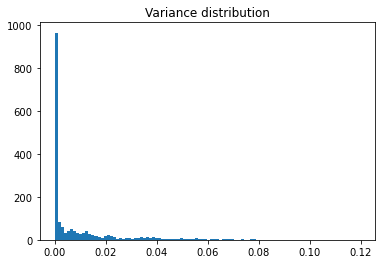

Variance threshold= 9.603693761854994e-10 Number of Features to remove: 1
Number of Features to retain: 1800
Variance threshold= 1.0302773931949328e-09 Number of Features to remove: 2
Number of Features to retain: 1799
Variance threshold= 1.1214278141317002e-09 Number of Features to remove: 3
Number of Features to retain: 1798
Variance threshold= 1.2350308255404317e-09 Number of Features to remove: 4
Number of Features to retain: 1797
Variance threshold= 1.37236530455729e-09 Number of Features to remove: 5
Number of Features to retain: 1796
Variance threshold= 1.5347831001082173e-09 Number of Features to remove: 6
Number of Features to retain: 1795
Variance threshold= 1.7237136115178704e-09 Number of Features to remove: 7
Number of Features to retain: 1794
Variance threshold= 1.9406686875269846e-09 Number of Features to remove: 8
Number of Features to retain: 1793
Variance threshold= 2.1872478706849e-09 Number of Features to remove: 9
Number of Features to retain: 1792
Variance thresho

Variance threshold= 8.47331660664834e-08 Number of Features to remove: 78
Number of Features to retain: 1723
Variance threshold= 8.474883642248201e-08 Number of Features to remove: 78
Number of Features to retain: 1723
Variance threshold= 8.499070733894126e-08 Number of Features to remove: 80
Number of Features to retain: 1721
Variance threshold= 8.502332875107103e-08 Number of Features to remove: 80
Number of Features to retain: 1721
Variance threshold= 8.526630187762787e-08 Number of Features to remove: 82
Number of Features to retain: 1719
Variance threshold= 8.531930358659475e-08 Number of Features to remove: 82
Number of Features to retain: 1719
Variance threshold= 8.555998452913675e-08 Number of Features to remove: 84
Number of Features to retain: 1717
Variance threshold= 8.563704814993038e-08 Number of Features to remove: 84
Number of Features to retain: 1717
Variance threshold= 8.58718000654868e-08 Number of Features to remove: 85
Number of Features to retain: 1716
Variance thr

Variance threshold= 1.0856106566917445e-07 Number of Features to remove: 154
Number of Features to retain: 1647
Variance threshold= 1.0934811546833742e-07 Number of Features to remove: 155
Number of Features to retain: 1646
Variance threshold= 1.0982327600169741e-07 Number of Features to remove: 156
Number of Features to retain: 1645
Variance threshold= 1.1043583957510973e-07 Number of Features to remove: 157
Number of Features to retain: 1644
Variance threshold= 1.1112656918763726e-07 Number of Features to remove: 158
Number of Features to retain: 1643
Variance threshold= 1.1155160814714357e-07 Number of Features to remove: 159
Number of Features to retain: 1642
Variance threshold= 1.1247194485451372e-07 Number of Features to remove: 160
Number of Features to retain: 1641
Variance threshold= 1.1269597798869065e-07 Number of Features to remove: 161
Number of Features to retain: 1640
Variance threshold= 1.1386043679400679e-07 Number of Features to remove: 163
Number of Features to retai

Variance threshold= 1.758068356004028e-07 Number of Features to remove: 231
Number of Features to retain: 1570
Variance threshold= 1.7704997397724666e-07 Number of Features to remove: 232
Number of Features to retain: 1569
Variance threshold= 1.7910387455146539e-07 Number of Features to remove: 233
Number of Features to retain: 1568
Variance threshold= 1.798365303305428e-07 Number of Features to remove: 234
Number of Features to retain: 1567
Variance threshold= 1.8249915661730224e-07 Number of Features to remove: 236
Number of Features to retain: 1565
Variance threshold= 1.826953119212822e-07 Number of Features to remove: 236
Number of Features to retain: 1565
Variance threshold= 1.8562849821794246e-07 Number of Features to remove: 237
Number of Features to retain: 1564
Variance threshold= 1.859957201509916e-07 Number of Features to remove: 238
Number of Features to retain: 1563
Variance threshold= 1.8801459436682608e-07 Number of Features to remove: 239
Number of Features to retain: 1

Variance threshold= 3.419956959819928e-07 Number of Features to remove: 307
Number of Features to retain: 1494
Variance threshold= 3.4515796379581887e-07 Number of Features to remove: 308
Number of Features to retain: 1493
Variance threshold= 3.5047115242381763e-07 Number of Features to remove: 309
Number of Features to retain: 1492
Variance threshold= 3.5281967517479223e-07 Number of Features to remove: 310
Number of Features to retain: 1491
Variance threshold= 3.5399757464695165e-07 Number of Features to remove: 311
Number of Features to retain: 1490
Variance threshold= 3.592247162241021e-07 Number of Features to remove: 312
Number of Features to retain: 1489
Variance threshold= 3.6072644487126936e-07 Number of Features to remove: 313
Number of Features to retain: 1488
Variance threshold= 3.682669404119098e-07 Number of Features to remove: 314
Number of Features to retain: 1487
Variance threshold= 3.688879630430021e-07 Number of Features to remove: 315
Number of Features to retain: 1

Variance threshold= 8.320866166841708e-07 Number of Features to remove: 388
Number of Features to retain: 1413
Variance threshold= 8.326659172225235e-07 Number of Features to remove: 388
Number of Features to retain: 1413
Variance threshold= 8.327412493086727e-07 Number of Features to remove: 389
Number of Features to retain: 1412
Variance threshold= 8.336945045491571e-07 Number of Features to remove: 389
Number of Features to retain: 1412
Variance threshold= 8.354523903224313e-07 Number of Features to remove: 390
Number of Features to retain: 1411
Variance threshold= 8.378191747648137e-07 Number of Features to remove: 391
Number of Features to retain: 1410
Variance threshold= 8.400527173127782e-07 Number of Features to remove: 392
Number of Features to retain: 1409
Variance threshold= 8.447757609395185e-07 Number of Features to remove: 393
Number of Features to retain: 1408
Variance threshold= 8.464062807869003e-07 Number of Features to remove: 394
Number of Features to retain: 1407
V

Variance threshold= 1.3672919317949737e-06 Number of Features to remove: 462
Number of Features to retain: 1339
Variance threshold= 1.3733442573913072e-06 Number of Features to remove: 463
Number of Features to retain: 1338
Variance threshold= 1.3873617958206223e-06 Number of Features to remove: 464
Number of Features to retain: 1337
Variance threshold= 1.4144368982859683e-06 Number of Features to remove: 465
Number of Features to retain: 1336
Variance threshold= 1.424482276669218e-06 Number of Features to remove: 466
Number of Features to retain: 1335
Variance threshold= 1.4295722862047985e-06 Number of Features to remove: 467
Number of Features to retain: 1334
Variance threshold= 1.4462992165287647e-06 Number of Features to remove: 468
Number of Features to retain: 1333
Variance threshold= 1.4665681892200424e-06 Number of Features to remove: 469
Number of Features to retain: 1332
Variance threshold= 1.4737932334439601e-06 Number of Features to remove: 470
Number of Features to retain

Variance threshold= 3.0701535173157723e-06 Number of Features to remove: 539
Number of Features to retain: 1262
Variance threshold= 3.1202127193151525e-06 Number of Features to remove: 540
Number of Features to retain: 1261
Variance threshold= 3.1468159034611974e-06 Number of Features to remove: 541
Number of Features to retain: 1260
Variance threshold= 3.165941905555605e-06 Number of Features to remove: 542
Number of Features to retain: 1259
Variance threshold= 3.2523603718889614e-06 Number of Features to remove: 543
Number of Features to retain: 1258
Variance threshold= 3.3010299563938454e-06 Number of Features to remove: 544
Number of Features to retain: 1257
Variance threshold= 3.3144193846682175e-06 Number of Features to remove: 545
Number of Features to retain: 1256
Variance threshold= 3.392283831532221e-06 Number of Features to remove: 546
Number of Features to retain: 1255
Variance threshold= 3.4038299731619164e-06 Number of Features to remove: 547
Number of Features to retain:

Variance threshold= 9.104962342112782e-06 Number of Features to remove: 615
Number of Features to retain: 1186
Variance threshold= 9.414607516021113e-06 Number of Features to remove: 616
Number of Features to retain: 1185
Variance threshold= 9.53628485103703e-06 Number of Features to remove: 617
Number of Features to retain: 1184
Variance threshold= 9.738510329468136e-06 Number of Features to remove: 618
Number of Features to retain: 1183
Variance threshold= 9.873215619855555e-06 Number of Features to remove: 620
Number of Features to retain: 1181
Variance threshold= 9.875538196576062e-06 Number of Features to remove: 620
Number of Features to retain: 1181
Variance threshold= 1.0081743326576537e-05 Number of Features to remove: 621
Number of Features to retain: 1180
Variance threshold= 1.0389818082875705e-05 Number of Features to remove: 622
Number of Features to retain: 1179
Variance threshold= 1.0431749053341586e-05 Number of Features to remove: 623
Number of Features to retain: 1178

Variance threshold= 4.037913603665967e-05 Number of Features to remove: 691
Number of Features to retain: 1110
Variance threshold= 4.111402629400886e-05 Number of Features to remove: 692
Number of Features to retain: 1109
Variance threshold= 4.197030165707756e-05 Number of Features to remove: 693
Number of Features to retain: 1108
Variance threshold= 4.2305229137613915e-05 Number of Features to remove: 694
Number of Features to retain: 1107
Variance threshold= 4.363495977008889e-05 Number of Features to remove: 695
Number of Features to retain: 1106
Variance threshold= 4.375977107950045e-05 Number of Features to remove: 696
Number of Features to retain: 1105
Variance threshold= 4.518424475307829e-05 Number of Features to remove: 697
Number of Features to retain: 1104
Variance threshold= 4.548936718824807e-05 Number of Features to remove: 698
Number of Features to retain: 1103
Variance threshold= 4.692567209554119e-05 Number of Features to remove: 699
Number of Features to retain: 1102


Variance threshold= 0.00019133492732208645 Number of Features to remove: 771
Number of Features to retain: 1030
Variance threshold= 0.00019768222137908783 Number of Features to remove: 772
Number of Features to retain: 1029
Variance threshold= 0.00019901462196385814 Number of Features to remove: 773
Number of Features to retain: 1028
Variance threshold= 0.00020280877798793036 Number of Features to remove: 774
Number of Features to retain: 1027
Variance threshold= 0.00020334680714990963 Number of Features to remove: 776
Number of Features to retain: 1025
Variance threshold= 0.00020344603905360215 Number of Features to remove: 776
Number of Features to retain: 1025
Variance threshold= 0.00021060963596906336 Number of Features to remove: 777
Number of Features to retain: 1024
Variance threshold= 0.00021271948935623757 Number of Features to remove: 778
Number of Features to retain: 1023
Variance threshold= 0.00021476018667206903 Number of Features to remove: 779
Number of Features to retai

Variance threshold= 0.0005433725937549287 Number of Features to remove: 849
Number of Features to retain: 952
Variance threshold= 0.000544685294338541 Number of Features to remove: 850
Number of Features to retain: 951
Variance threshold= 0.0005471340836924648 Number of Features to remove: 852
Number of Features to retain: 949
Variance threshold= 0.0005472674641122049 Number of Features to remove: 852
Number of Features to retain: 949
Variance threshold= 0.0005501040161999806 Number of Features to remove: 854
Number of Features to retain: 947
Variance threshold= 0.0005503827455402047 Number of Features to remove: 854
Number of Features to retain: 947
Variance threshold= 0.0005540070111180082 Number of Features to remove: 855
Number of Features to retain: 946
Variance threshold= 0.000563302256970128 Number of Features to remove: 856
Number of Features to retain: 945
Variance threshold= 0.0005795021583559431 Number of Features to remove: 857
Number of Features to retain: 944
Variance thr

Variance threshold= 0.0009347634686061156 Number of Features to remove: 929
Number of Features to retain: 872
Variance threshold= 0.0009461511166552308 Number of Features to remove: 930
Number of Features to retain: 871
Variance threshold= 0.0009532296765672201 Number of Features to remove: 931
Number of Features to retain: 870
Variance threshold= 0.0009547879654682403 Number of Features to remove: 932
Number of Features to retain: 869
Variance threshold= 0.0009582633841166689 Number of Features to remove: 934
Number of Features to retain: 867
Variance threshold= 0.0009592953415544972 Number of Features to remove: 934
Number of Features to retain: 867
Variance threshold= 0.000964761364110643 Number of Features to remove: 935
Number of Features to retain: 866
Variance threshold= 0.0009693698836002492 Number of Features to remove: 936
Number of Features to retain: 865
Variance threshold= 0.000972635943293046 Number of Features to remove: 937
Number of Features to retain: 864
Variance thr

Variance threshold= 0.0018995177262989761 Number of Features to remove: 1003
Number of Features to retain: 798
Variance threshold= 0.0019135497901586146 Number of Features to remove: 1004
Number of Features to retain: 797
Variance threshold= 0.0019177338112501081 Number of Features to remove: 1005
Number of Features to retain: 796
Variance threshold= 0.0019206668564498229 Number of Features to remove: 1006
Number of Features to retain: 795
Variance threshold= 0.0019313172181176926 Number of Features to remove: 1007
Number of Features to retain: 794
Variance threshold= 0.0019340012442232602 Number of Features to remove: 1008
Number of Features to retain: 793
Variance threshold= 0.001946743472621293 Number of Features to remove: 1009
Number of Features to retain: 792
Variance threshold= 0.001963703776016588 Number of Features to remove: 1010
Number of Features to retain: 791
Variance threshold= 0.001971352340613167 Number of Features to remove: 1012
Number of Features to retain: 789
Vari

Variance threshold= 0.003096266787401547 Number of Features to remove: 1084
Number of Features to retain: 717
Variance threshold= 0.0031016939183911643 Number of Features to remove: 1085
Number of Features to retain: 716
Variance threshold= 0.0031611083159436434 Number of Features to remove: 1086
Number of Features to retain: 715
Variance threshold= 0.003179353874379969 Number of Features to remove: 1087
Number of Features to retain: 714
Variance threshold= 0.0031885040996742853 Number of Features to remove: 1088
Number of Features to retain: 713
Variance threshold= 0.003194575239655785 Number of Features to remove: 1089
Number of Features to retain: 712
Variance threshold= 0.0032030192111107197 Number of Features to remove: 1090
Number of Features to retain: 711
Variance threshold= 0.0032112579992896267 Number of Features to remove: 1091
Number of Features to retain: 710
Variance threshold= 0.0032370385243300744 Number of Features to remove: 1092
Number of Features to retain: 709
Vari

Variance threshold= 0.005545085053679615 Number of Features to remove: 1162
Number of Features to retain: 639
Variance threshold= 0.005584655642466709 Number of Features to remove: 1164
Number of Features to retain: 637
Variance threshold= 0.005584750409115347 Number of Features to remove: 1164
Number of Features to retain: 637
Variance threshold= 0.0056175198852486665 Number of Features to remove: 1166
Number of Features to retain: 635
Variance threshold= 0.005618420825431086 Number of Features to remove: 1166
Number of Features to retain: 635
Variance threshold= 0.005652507671808793 Number of Features to remove: 1167
Number of Features to retain: 634
Variance threshold= 0.005695604987760198 Number of Features to remove: 1169
Number of Features to retain: 632
Variance threshold= 0.005697035647867194 Number of Features to remove: 1169
Number of Features to retain: 632
Variance threshold= 0.00574415205810349 Number of Features to remove: 1170
Number of Features to retain: 631
Variance t

Variance threshold= 0.00754328982542101 Number of Features to remove: 1241
Number of Features to retain: 560
Variance threshold= 0.007553394165786075 Number of Features to remove: 1242
Number of Features to retain: 559
Variance threshold= 0.007633294024123865 Number of Features to remove: 1243
Number of Features to retain: 558
Variance threshold= 0.007680915022917501 Number of Features to remove: 1244
Number of Features to retain: 557
Variance threshold= 0.007719772708801132 Number of Features to remove: 1245
Number of Features to retain: 556
Variance threshold= 0.007780982948734744 Number of Features to remove: 1247
Number of Features to retain: 554
Variance threshold= 0.0077819442742582895 Number of Features to remove: 1247
Number of Features to retain: 554
Variance threshold= 0.007794203258542464 Number of Features to remove: 1248
Number of Features to retain: 553
Variance threshold= 0.007834307325802111 Number of Features to remove: 1249
Number of Features to retain: 552
Variance t

Variance threshold= 0.010130906771504309 Number of Features to remove: 1322
Number of Features to retain: 479
Variance threshold= 0.01013413208243218 Number of Features to remove: 1322
Number of Features to retain: 479
Variance threshold= 0.010174343135196807 Number of Features to remove: 1323
Number of Features to retain: 478
Variance threshold= 0.0102711784866382 Number of Features to remove: 1324
Number of Features to retain: 477
Variance threshold= 0.010369740634997581 Number of Features to remove: 1325
Number of Features to retain: 476
Variance threshold= 0.010479214287908154 Number of Features to remove: 1326
Number of Features to retain: 475
Variance threshold= 0.010512591267515331 Number of Features to remove: 1327
Number of Features to retain: 474
Variance threshold= 0.010572068065794896 Number of Features to remove: 1329
Number of Features to retain: 472
Variance threshold= 0.010579886843268053 Number of Features to remove: 1329
Number of Features to retain: 472
Variance thre

Variance threshold= 0.012974735655964333 Number of Features to remove: 1396
Number of Features to retain: 405
Variance threshold= 0.01301023818276163 Number of Features to remove: 1399
Number of Features to retain: 402
Variance threshold= 0.013018154206924483 Number of Features to remove: 1399
Number of Features to retain: 402
Variance threshold= 0.013024109742595606 Number of Features to remove: 1399
Number of Features to retain: 402
Variance threshold= 0.013042182802086506 Number of Features to remove: 1400
Number of Features to retain: 401
Variance threshold= 0.013088685912820213 Number of Features to remove: 1401
Number of Features to retain: 400
Variance threshold= 0.013132039025983273 Number of Features to remove: 1403
Number of Features to retain: 398
Variance threshold= 0.013137193772800876 Number of Features to remove: 1403
Number of Features to retain: 398
Variance threshold= 0.013158710647233247 Number of Features to remove: 1404
Number of Features to retain: 397
Variance th

Variance threshold= 0.017281800408555897 Number of Features to remove: 1474
Number of Features to retain: 327
Variance threshold= 0.017334187220028687 Number of Features to remove: 1476
Number of Features to retain: 325
Variance threshold= 0.017342684288202084 Number of Features to remove: 1477
Number of Features to retain: 324
Variance threshold= 0.017361094628184505 Number of Features to remove: 1478
Number of Features to retain: 323
Variance threshold= 0.017377470932691902 Number of Features to remove: 1478
Number of Features to retain: 323
Variance threshold= 0.017503365927868875 Number of Features to remove: 1479
Number of Features to retain: 322
Variance threshold= 0.01766058148646032 Number of Features to remove: 1480
Number of Features to retain: 321
Variance threshold= 0.017714453969977288 Number of Features to remove: 1481
Number of Features to retain: 320
Variance threshold= 0.017811084718894758 Number of Features to remove: 1482
Number of Features to retain: 319
Variance th

Variance threshold= 0.023190052704447954 Number of Features to remove: 1552
Number of Features to retain: 249
Variance threshold= 0.023253345262402993 Number of Features to remove: 1554
Number of Features to retain: 247
Variance threshold= 0.023276268488667644 Number of Features to remove: 1554
Number of Features to retain: 247
Variance threshold= 0.023461044522085518 Number of Features to remove: 1555
Number of Features to retain: 246
Variance threshold= 0.023578312212051745 Number of Features to remove: 1556
Number of Features to retain: 245
Variance threshold= 0.023721763230139435 Number of Features to remove: 1557
Number of Features to retain: 244
Variance threshold= 0.0238369382893452 Number of Features to remove: 1558
Number of Features to retain: 243
Variance threshold= 0.023947074826683075 Number of Features to remove: 1559
Number of Features to retain: 242
Variance threshold= 0.02401277656002241 Number of Features to remove: 1560
Number of Features to retain: 241
Variance thre

Variance threshold= 0.03423024608411758 Number of Features to remove: 1629
Number of Features to retain: 172
Variance threshold= 0.03441251155178332 Number of Features to remove: 1631
Number of Features to retain: 170
Variance threshold= 0.034440909838586505 Number of Features to remove: 1631
Number of Features to retain: 170
Variance threshold= 0.03456389626052585 Number of Features to remove: 1632
Number of Features to retain: 169
Variance threshold= 0.03481380068861177 Number of Features to remove: 1634
Number of Features to retain: 167
Variance threshold= 0.03481521730704959 Number of Features to remove: 1634
Number of Features to retain: 167
Variance threshold= 0.03491745696379071 Number of Features to remove: 1636
Number of Features to retain: 165
Variance threshold= 0.034952956864542625 Number of Features to remove: 1636
Number of Features to retain: 165
Variance threshold= 0.035350217591453646 Number of Features to remove: 1637
Number of Features to retain: 164
Variance thresho

Variance threshold= 0.04528829705669511 Number of Features to remove: 1709
Number of Features to retain: 92
Variance threshold= 0.04552628888507603 Number of Features to remove: 1710
Number of Features to retain: 91
Variance threshold= 0.04600986670876793 Number of Features to remove: 1711
Number of Features to retain: 90
Variance threshold= 0.04611013975467045 Number of Features to remove: 1712
Number of Features to retain: 89
Variance threshold= 0.046318863611337205 Number of Features to remove: 1713
Number of Features to retain: 88
Variance threshold= 0.04646315799068603 Number of Features to remove: 1714
Number of Features to retain: 87
Variance threshold= 0.04663546597730424 Number of Features to remove: 1715
Number of Features to retain: 86
Variance threshold= 0.04682779723721714 Number of Features to remove: 1716
Number of Features to retain: 85
Variance threshold= 0.047660668860976106 Number of Features to remove: 1717
Number of Features to retain: 84
Variance threshold= 0.0477

Variance threshold= 0.07734651123662897 Number of Features to remove: 1791
Number of Features to retain: 10
Variance threshold= 0.07765689705702263 Number of Features to remove: 1792
Number of Features to retain: 9
Variance threshold= 0.07876888710797768 Number of Features to remove: 1793
Number of Features to retain: 8
Variance threshold= 0.08624552233402569 Number of Features to remove: 1794
Number of Features to retain: 7
Variance threshold= 0.0914464559643742 Number of Features to remove: 1795
Number of Features to retain: 6
Variance threshold= 0.09804616246273816 Number of Features to remove: 1796
Number of Features to retain: 5
Variance threshold= 0.1051133257262181 Number of Features to remove: 1797
Number of Features to retain: 4
Variance threshold= 0.1091342272161009 Number of Features to remove: 1798
Number of Features to retain: 3
Variance threshold= 0.11514184116407677 Number of Features to remove: 1799
Number of Features to retain: 2
Variance threshold= 0.11705739536315639

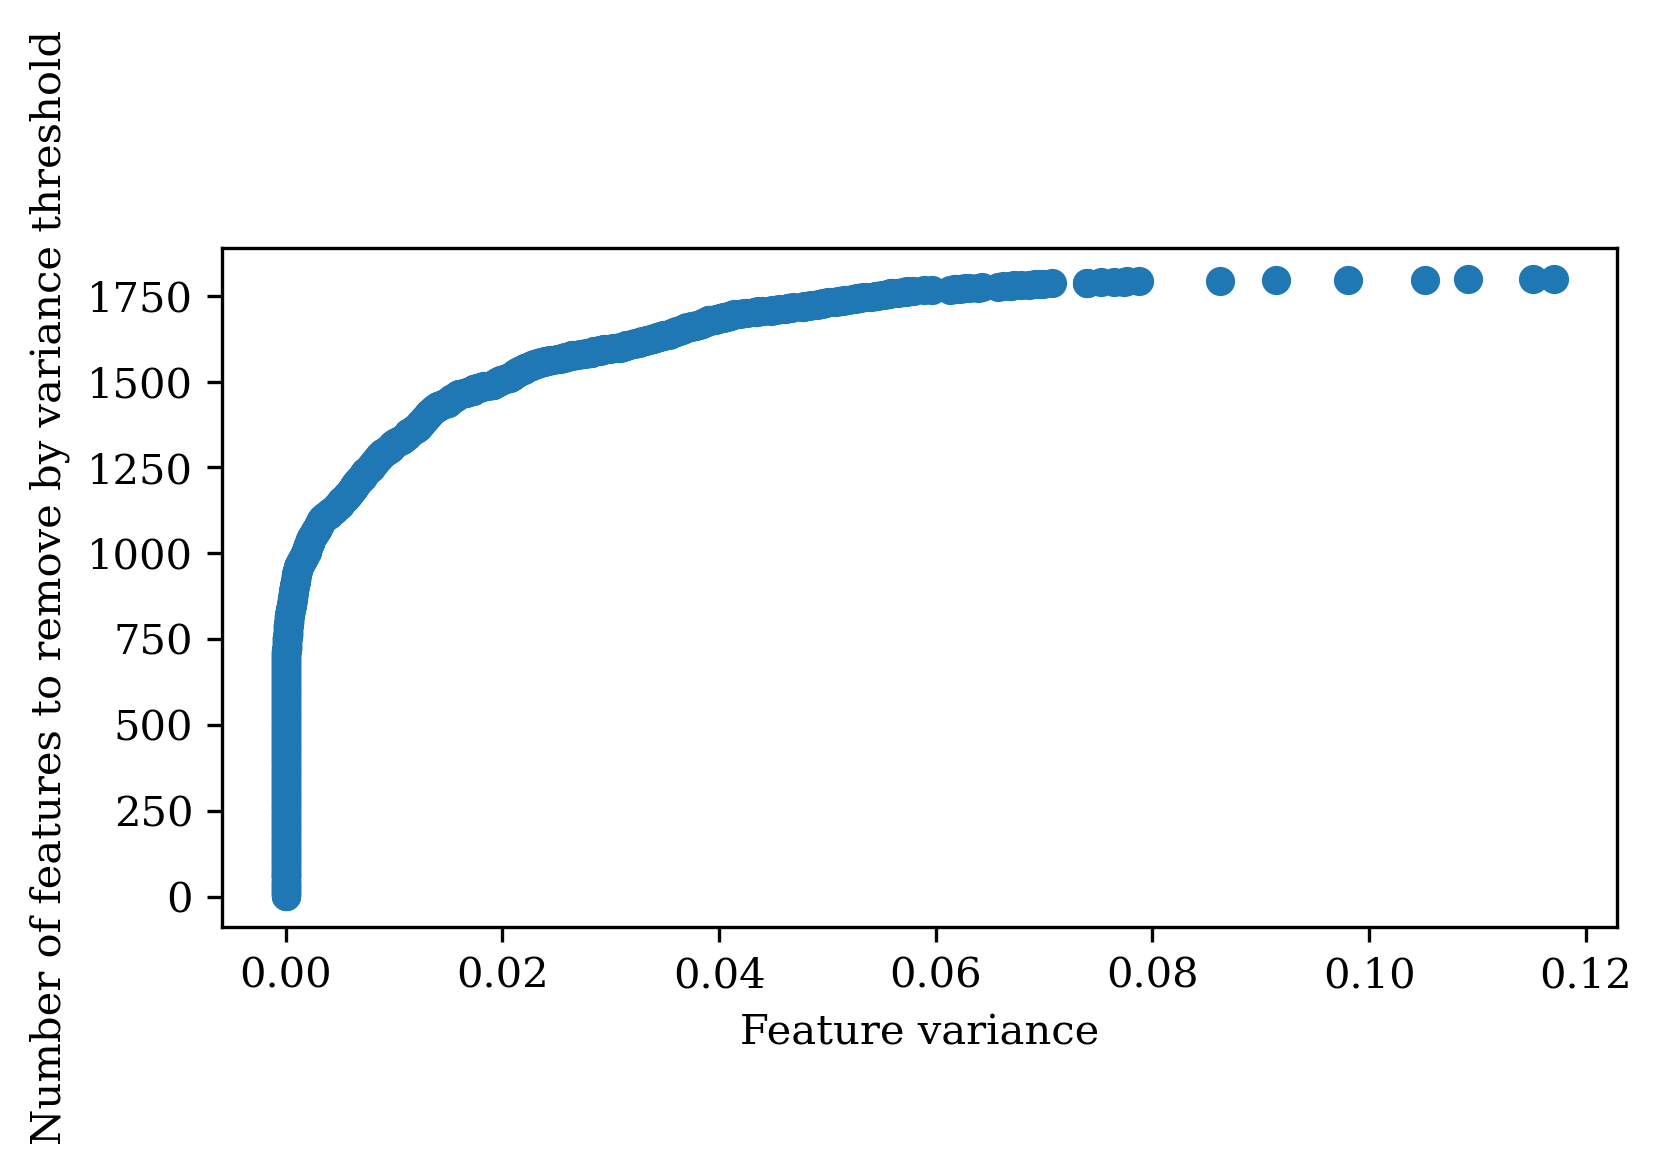

In [9]:
check_low_variance(X_train)

In [10]:
def low_variance_feature_selection(X_Train, df, df1, df2, threshold):
    sel = VarianceThreshold(threshold)
    sel.fit_transform(X_Train)
    print("Features to be removed:",(~sel.get_support()).sum())
    
    #Capture features to retain from Training set
    feat_names = X_Train.columns[sel.get_support()]
    
    #Transform the full dataset and unique drug compound dataset
    X =  df.drop(['Drug','Class'],axis=1)
    X_df = sel.transform(X)
    X_df = pd.DataFrame(X_df,columns=feat_names)
    
    X1 = df1.drop(['Drug','Class'],axis=1)
    X_df_unique = sel.transform(X1)
    X_df_unique = pd.DataFrame(X_df_unique,columns=feat_names)
    
    X2 = df2.drop(['Drug','Class'],axis=1)
    X_df_unique2 = sel.transform(X2)
    X_df_unique2 = pd.DataFrame(X_df_unique2,columns=feat_names)
    
    # Features retained
    x_retained = [float(item) for item in feat_names]
    return X_df, X_df_unique, X_df_unique2, x_retained

In [11]:
df_variance, df_unique_variance,df_total_IR_unique_variance,x_retained = low_variance_feature_selection(X_train, df, df_unique,df_total_IR_unique, 9.875538196576069e-06)

Features to be removed: 620


In [12]:
print(df_variance.shape)
print(df_unique_variance.shape)
print(df_total_IR_unique_variance.shape)
print(len(x_retained))

(930, 1181)
(127, 1181)
(127, 1181)
1181


In [13]:
df_variance.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance.csv", index=False)
df_unique_variance.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance - Unique compounds.csv", index=False)
df_total_IR_unique_variance.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) conformer weighted total IR low variance - Unique compounds.csv", index=False)

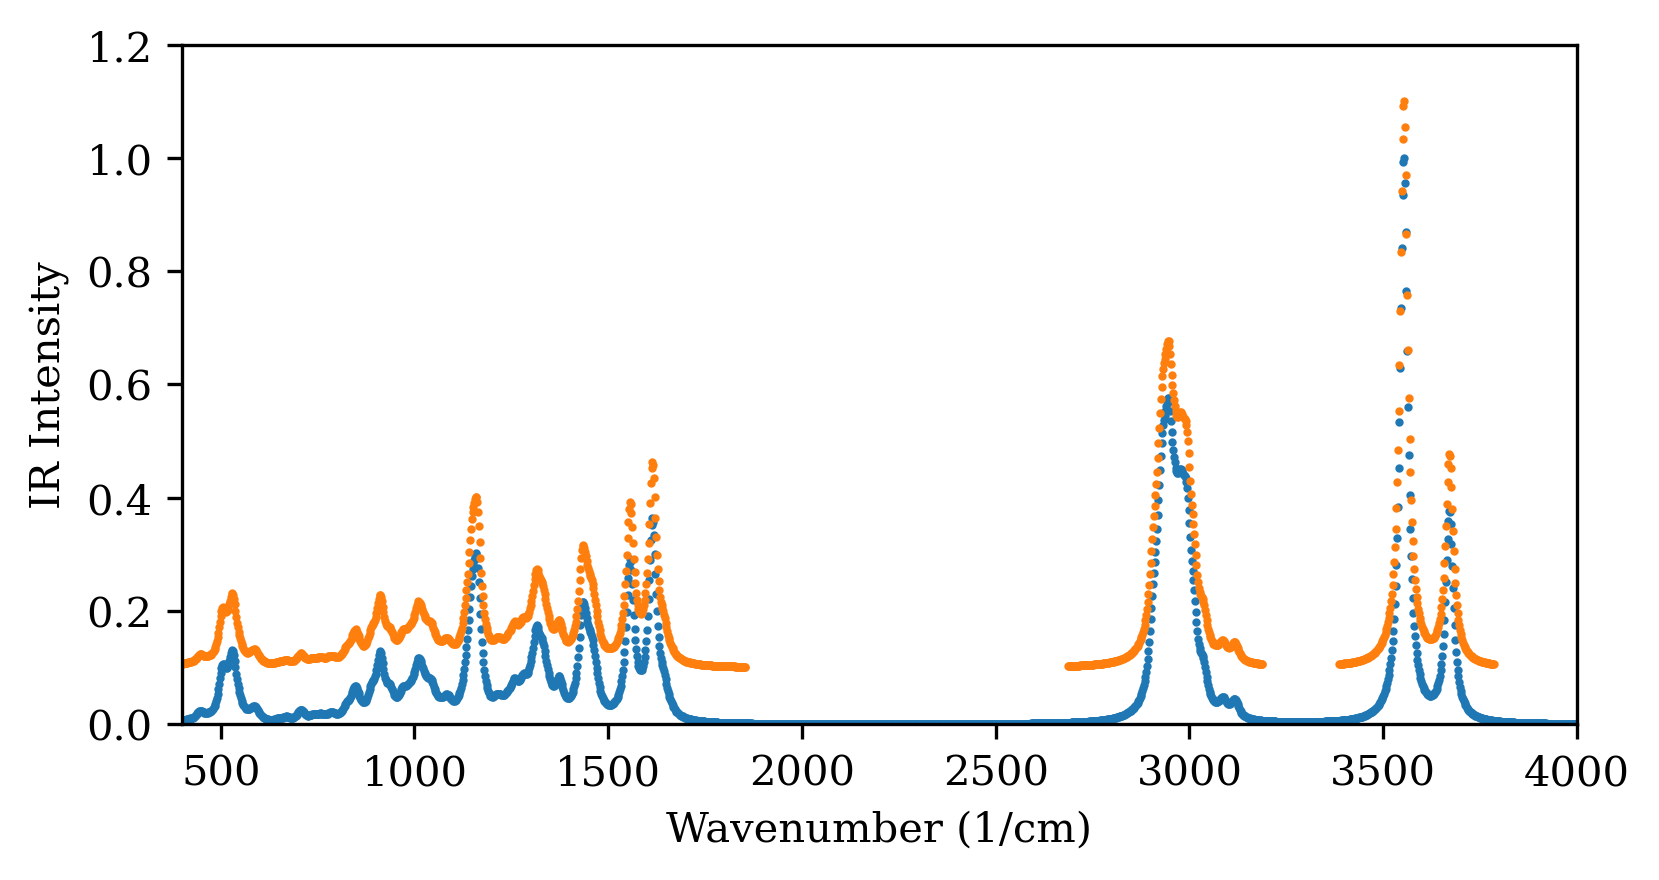

In [53]:
fig = plt.figure(figsize=(6,3), dpi=300)
plt.rc('font', family='serif', size = 10)
plt.xlabel('Wavenumber (1/cm)')
plt.ylabel('IR Intensity')
plt.xlim(400, 4000)
plt.ylim(0,1.2)
plt.scatter(full_feature,df.iloc[600,2:], s=1)
plt.scatter(x_retained,df_variance.iloc[600,:]+0.1, s=1)
plt.show()

## II. Feature selection

In [54]:
from skfeature.function.similarity_based import SPEC
from skfeature.function.sparse_learning_based import NDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
from skfeature.utility.sparse_learning import feature_ranking

#### Split the df_variance into 90% training and 10% test set for feature selection use kFold

* For each iteration, use training set to calculate feature importance score
* Repeat for 10-times 
* Plot scaled importance for each feature

In [365]:
X = df_variance
Y = df['Class'].astype('int64')

In [366]:
features = []
for col in df_variance.columns:
    features.append(col)

len(features)
features = [float(item) for item in features]

Check original X_train class distribution

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 28  46  77  17  75 112  70  46  10  59   9  67  78  72 117  47]
930


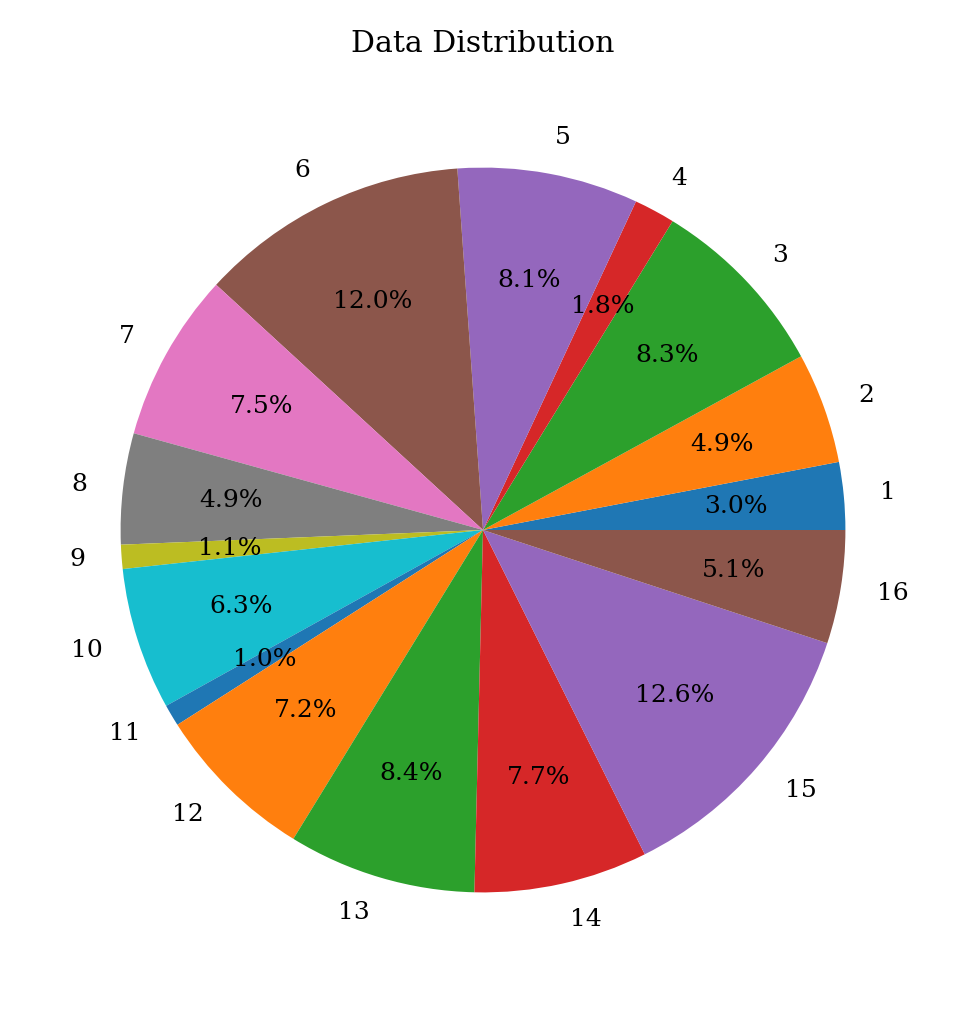

In [368]:
class_count = np.unique(Y,return_counts=True)
print(class_count[0])
print(class_count[1])
print(class_count[1].sum())
fig = plt.figure(figsize=(4,4), dpi=300)
plt.rc('font', family='serif', size = 6)
plt.pie(class_count[1],labels=class_count[0],autopct='%1.1f%%',pctdistance=0.7)
plt.title('Data Distribution')
plt.show()
fig.savefig(path+"Figure. DFT IR spectra dataset class distribution.png",  bbox_inches='tight')

* Class K = 6 and 15 have the most samples.
* SMOTE will oversample all classes to have the same number of samples as K = 15
* X_train after SMOTE with 1680 samples for 16 classes

In [212]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
sm = SMOTE( random_state=42)
X_train_resample_base=[]
Y_train_resample_base=[]
X_train_base=[]
Y_train_base=[]
X_test_base=[]
Y_test_base=[]
for train_index, test_index in kf.split(df_variance):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index] 
    X_train_base.append(X_train)
    Y_train_base.append(Y_train)
    
    X_train_resample, Y_train_resample = sm.fit_resample(X_train,Y_train)
    
    X_train_resample_base.append(X_train_resample)
    X_test_base.append(X_test)
    Y_train_resample_base.append(Y_train_resample)
    Y_test_base.append(Y_test)
    print("Iteration:", )
    print("Resampled:", X_train_resample.shape, Y_train_resample.shape)
    print("Test:",X_test.shape, Y_test.shape)
    print("Train:", X_train.shape, Y_train.shape)

Iteration:
Resampled: (1680, 1181) (1680,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1728, 1181) (1728,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1744, 1181) (1744,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1728, 1181) (1728,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1664, 1181) (1664,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1712, 1181) (1712,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1696, 1181) (1696,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1632, 1181) (1632,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1712, 1181) (1712,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1632, 1181) (1632,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)


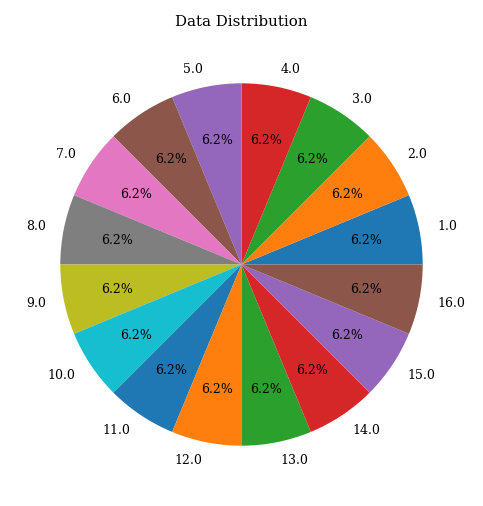

In [213]:
class_count = np.unique(Y_train_resample_base[0],return_counts=True)

fig = plt.figure(figsize=(4,4), dpi=150)
plt.rc('font', family='serif', size = 6)
plt.pie(class_count[1],labels=class_count[0],autopct='%1.1f%%',pctdistance=0.7)
plt.title('Data Distribution')
plt.show()

### Calculate feature importance score (scaled to 0 ~ 1) and plot comparison of four filter methods use 10-Kfold iteration

In [217]:
X_train_base[0].values

array([[8.91301935e-03, 8.55724550e-03, 8.18829006e-03, ...,
        7.52271403e-05, 7.42969801e-05, 7.33727514e-05],
       [8.73276423e-03, 8.33924154e-03, 7.89601390e-03, ...,
        7.22768488e-05, 7.13824081e-05, 7.04936844e-05],
       [5.67820057e-03, 6.16145812e-03, 6.72549675e-03, ...,
        6.90704032e-05, 6.82133319e-05, 6.73617999e-05],
       ...,
       [7.15693472e-02, 6.72038904e-02, 6.26503374e-02, ...,
        1.35143046e-03, 1.32191665e-03, 1.29313796e-03],
       [4.42342221e-02, 4.62831171e-02, 4.94380066e-02, ...,
        1.35694090e-03, 1.32708070e-03, 1.29796971e-03],
       [5.05639269e-02, 4.74747040e-02, 4.52250295e-02, ...,
        1.13166747e-03, 1.10715910e-03, 1.08325651e-03]])

In [284]:
def feature_rank(X_train,method):
    X = X_train.values
    if method.lower() == 'spec_rank':
        kwargs = {'style': 0}
        score = SPEC.spec(X, **kwargs)
    
    elif method.lower() == 'lap_rank':
        kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
        W = construct_W.construct_W(X, **kwargs_W)
        score = lap_score.lap_score(X, W=W)
        score = score**-1
    
    elif method.lower() == 'ndfs_rank':
        kwargs = {"metric": "euclidean", "neighborMode": "knn", "weightMode": "heatKernel", "k": 5, 't': 1}
        W = construct_W.construct_W(X, **kwargs)
        Weight = NDFS.ndfs(X, W=W, n_clusters=20)
        score = (Weight*Weight).sum(1)
    
    elif method.lower() == 'udfs_rank':
        Weight = UDFS.udfs(X, gamma=0.1, n_clusters=16)
        score = (Weight*Weight).sum(1)

    return score

In [312]:
def average_feature_rank(Data, method):
    df_tmp = pd.DataFrame()
    df_tmp['features'] = features
    for i in range(10):
        print('fold'+str(i+1))
        X_train = Data[i]
        score = feature_rank(X_train, method)
        score = min_max_scaler(score)
        #print(score[0:20])
        df_tmp['fold'+str(i+1)] = score
    print("10 iterations done")
    df_tmp['mean_score'] = df_tmp.iloc[:,1:11].mean(axis=1)
    return df_tmp

In [361]:
df_rank = average_feature_rank(X_train_base, "UDFS_rank")

df_rank.to_csv(path+"Feature importance score UDFS.csv",index=False)

fold1
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
fold10
10 iterations done


In [362]:
df_resample_rank = average_feature_rank(X_train_resample_base, "UDFS_rank")

df_resample_rank.to_csv(path+"Feature importance score UDFS - SMOTE.csv",index=False)

fold1
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
fold10
10 iterations done


In [360]:
df_rank[df_rank['mean_score']==max(df_rank.mean_score)]

,features,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean_score
563,1526.0,0.000205,0.546667,0.613968,1.0,0.914852,1.0,1.0,0.827072,0.956749,1.0,0.785951


In [364]:
df_rank.shape

(1181, 12)

#### Scaled feature importance score plots

In [10]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"
SMOTE = ' - SMOTE'

In [37]:
def score_plot(method,SMOTE):
    file1 = path+'Feature importance score '+method+'.csv'
    file2 = path+'Feature importance score '+method+SMOTE+'.csv'
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    x = df1.features
    y1 = df1.mean_score
    y2 = df2.mean_score
    
    fig = plt.figure(figsize=(6,2), dpi=600)
    plt.rc('font', family='serif', size = 8)
    plt.xlabel('Wavenumber (1/cm)')
    plt.ylabel('Feature importance score')
    plt.xlim(380, 3790)
    plt.xticks(np.arange(380, 3790,300))
    plt.ylim(0,1.05)
    plt.bar(x,y1, label = "Without SMOTE", alpha=0.7,width=1.5)
    plt.bar(x,y2, label = "SMOTE", alpha=0.5,width=1.5)
    plt.legend()
    legend = plt.legend(loc='upper left', shadow=True, fontsize=8)
    plt.show()
    fig.savefig(path+"Feature importance score "+method+" with vs. without SMOTE.png", bbox_inches='tight')

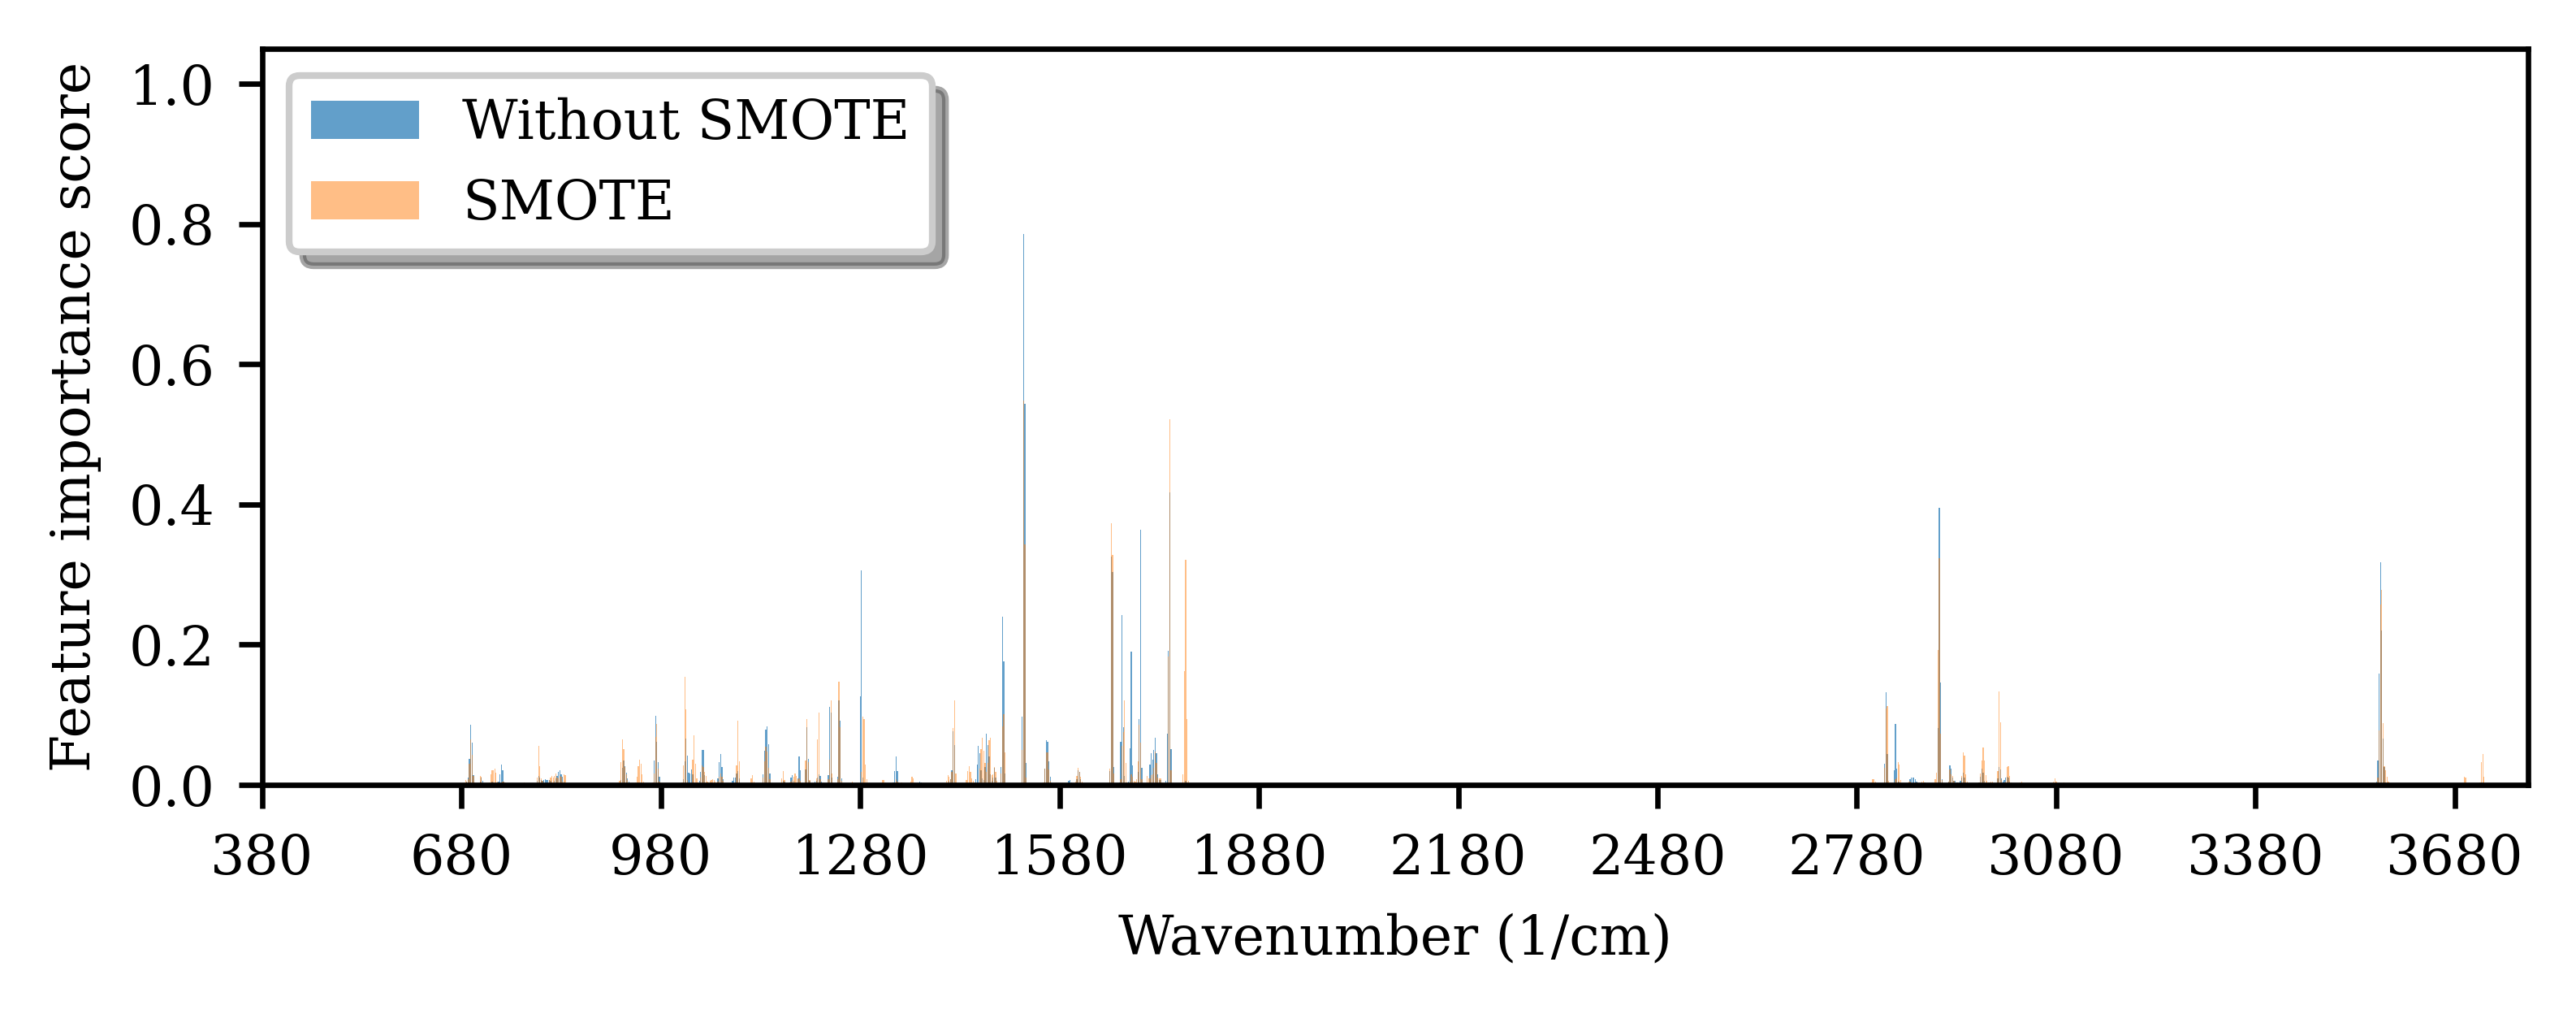

In [41]:
score_plot('NDFS',SMOTE)